<a href="https://colab.research.google.com/github/tuananh1006/Torch_Practice/blob/main/MultiClassCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%% packages
import requests
import urllib.request
from pathlib import Path

#%%
def get_dog_images(breed, count=100, type='train'):
    available_breeds = ['affenpinscher', 'african', 'airedale', 'akita', 'appenzeller', 'australian', 'basenji', 'beagle', 'bluetick', 'borzoi', 'bouvier', 'boxer', 'brabancon', 'briard', 'buhund', 'bulldog', 'bullterrier', 'cattledog', 'chihuahua', 'chow', 'clumber', 'cockapoo', 'collie', 'coonhound', 'corgi', 'cotondetulear', 'dachshund', 'dalmatian', 'dane', 'deerhound', 'dhole', 'dingo', 'doberman', 'elkhound', 'entlebucher', 'eskimo', 'finnish', 'frise', 'germanshepherd', 'greyhound', 'groenendael', 'havanese', 'hound', 'husky', 'keeshond', 'kelpie', 'komondor', 'kuvasz', 'labradoodle', 'labrador', 'leonberg', 'lhasa', 'malamute', 'malinois', 'maltese', 'mastiff', 'mexicanhairless', 'mix', 'mountain', 'newfoundland', 'otterhound', 'ovcharka', 'papillon', 'pekinese', 'pembroke', 'pinscher', 'pitbull', 'pointer', 'pomeranian', 'poodle', 'pug', 'puggle', 'pyrenees', 'redbone', 'retriever', 'ridgeback', 'rottweiler', 'saluki', 'samoyed', 'schipperke', 'schnauzer', 'setter', 'sheepdog', 'shiba', 'shihtzu', 'spaniel', 'springer', 'stbernard', 'terrier', 'tervuren', 'vizsla', 'waterdog', 'weimaraner', 'whippet', 'wolfhound']
    for i in range(count):
        if breed not in available_breeds:
            raise ValueError('Breed not available')
        else:
            API = f'https://dog.ceo/api/breed/{breed}/images/random'

        img_url = requests.get(API).json()['message']
        # create folder if necessary
        breed_path = f"{type}/{breed}"
        Path(breed_path).mkdir(parents=True, exist_ok=True)

        # download an image and save it in folder
        img = urllib.request.urlretrieve(img_url, f"{breed_path}/{breed}_{i}.jpg")
    return None

def get_breeds():
    API = 'https://dog.ceo/api/breeds/list/all'
    breeds = requests.get(API).json()['message']
    return breeds.keys()

# %% get train images
get_dog_images('affenpinscher')
get_dog_images('corgi')
get_dog_images('akita')
#%% get test images
get_dog_images('affenpinscher', type='test', count=20)
get_dog_images('corgi', type='test', count=20)
get_dog_images('akita', type='test', count=20)


In [10]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
from PIL import Image
import numpy as np
img=Image.open('./train/akita/akita_0.jpg')

In [15]:
img_array=np.asarray(img)
img_array.shape

(384, 512, 3)

In [16]:
transform=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomRotation(10),
    transforms.CenterCrop(100),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize([0.5],[0.5])
])

In [17]:
import matplotlib.pyplot as plt
def show_img(img):
  img=img*2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))

In [18]:
train_set=torchvision.datasets.ImageFolder(root='./train',transform=transform)
test_set=torchvision.datasets.ImageFolder(root='./test',transform=transform)

In [19]:
from torch.utils.data import DataLoader
train_loader=DataLoader(train_set,batch_size=32,shuffle=True)
test_loader=DataLoader(test_set,batch_size=32,shuffle=True)

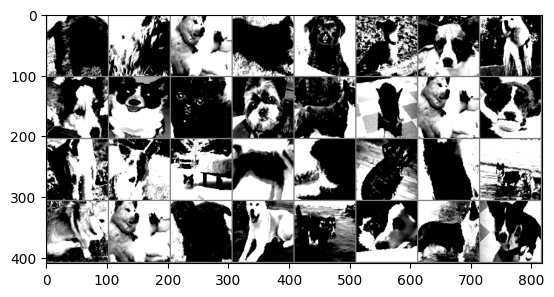

In [23]:
img_0=iter(train_loader)
img,label=next(img_0)
show_img(torchvision.utils.make_grid(img))

In [56]:
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(1,6,3) #148 148 6
    self.conv2=nn.Conv2d(6,16,3) #72 72 16
    self.pool=nn.MaxPool2d(2,2)
    self.fc1=nn.Linear(8464,120)
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,3)
    self.relu=nn.ReLU()
    self.softmax=nn.Softmax(dim=1)
  def forward(self,x):
    x=self.conv1(x)
    x=self.relu(x)
    x=self.pool(x)
    x=self.conv2(x)
    x=self.relu(x)
    x=self.pool(x)
    x=torch.flatten(x,1)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)
    x=self.relu(x)
    x=self.fc3(x)
    x=self.softmax(x)
    return x

In [63]:
loss_f=nn.CrossEntropyLoss()
model=MyModel()
#optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
optimizer=optim.Adam(model.parameters(),lr=0.001)
epochs=30
losses=[]

In [64]:
for epoch in range(epochs):
  for i,data in enumerate(train_loader,0):
    inputs,labels=data
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_f(outputs.squeeze(1),labels)
    loss.backward()
    optimizer.step()
  losses.append(loss.item())
  print(f'epoch {epoch+1} loss: {loss.item()}')

epoch 1 loss: 1.00607168674469
epoch 2 loss: 1.0236917734146118
epoch 3 loss: 0.7809180617332458
epoch 4 loss: 0.6950521469116211
epoch 5 loss: 0.7170817852020264
epoch 6 loss: 0.6211990714073181
epoch 7 loss: 0.6066732406616211
epoch 8 loss: 0.7431506514549255
epoch 9 loss: 0.6408078074455261
epoch 10 loss: 0.8825428485870361
epoch 11 loss: 1.1324821710586548
epoch 12 loss: 0.7647702693939209
epoch 13 loss: 0.6643379330635071
epoch 14 loss: 0.7192113399505615
epoch 15 loss: 0.7925557494163513
epoch 16 loss: 0.5533797144889832
epoch 17 loss: 0.6305325627326965
epoch 18 loss: 0.5737760663032532
epoch 19 loss: 0.7983450889587402
epoch 20 loss: 0.6484444737434387
epoch 21 loss: 0.5929316878318787
epoch 22 loss: 0.6871338486671448
epoch 23 loss: 0.5529921054840088
epoch 24 loss: 0.5867472290992737
epoch 25 loss: 0.64047771692276
epoch 26 loss: 0.6256157755851746
epoch 27 loss: 0.6322810649871826
epoch 28 loss: 0.5668057799339294
epoch 29 loss: 0.5542519688606262
epoch 30 loss: 0.5519683957

<Axes: >

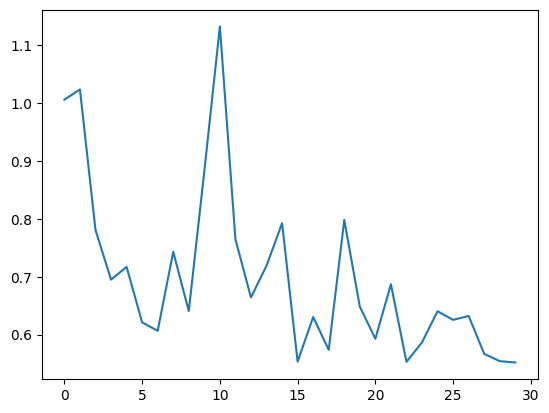

In [65]:
import seaborn as sns
sns.lineplot(x=range(epochs),y=losses)

In [66]:
y_pred=[]
y_test=[]
with torch.no_grad():
  for data in test_loader:
    inputs,labels=data
    outputs=model(inputs)
    _,predicted=torch.max(outputs,1)
    y_pred.extend(predicted.numpy())
    y_test.extend(labels.numpy())

In [67]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8833333333333333

In [68]:
from collections import Counter
Counter(y_test).most_common()[0][1]/len(y_test)

0.3333333333333333

In [69]:
class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(1,6,3) #148 148 6
    self.conv2=nn.Conv2d(6,16,3) #72 72 16
    self.pool=nn.MaxPool2d(2,2)
    self.fc1=nn.Linear(8464,120)
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,3)
    self.relu=nn.ReLU()
    self.logsoftmax=nn.LogSoftmax(dim=1)
  def forward(self,x):
    x=self.conv1(x)
    x=self.relu(x)
    x=self.pool(x)
    x=self.conv2(x)
    x=self.relu(x)
    x=self.pool(x)
    x=torch.flatten(x,1)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)
    x=self.relu(x)
    x=self.fc3(x)
    x=self.logsoftmax(x)
    return x
loss_f=nn.CrossEntropyLoss()
model=MyModel()
#optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
optimizer=optim.Adam(model.parameters(),lr=0.001)
epochs=30
losses=[]
for epoch in range(epochs):
  for i,data in enumerate(train_loader,0):
    inputs,labels=data
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_f(outputs.squeeze(1),labels)
    loss.backward()
    optimizer.step()
  losses.append(loss.item())
  print(f'epoch {epoch+1} loss: {loss.item()}')
y_pred=[]
y_test=[]
with torch.no_grad():
  for data in test_loader:
    inputs,labels=data
    outputs=model(inputs)
    _,predicted=torch.max(outputs,1)
    y_pred.extend(predicted.numpy())
    y_test.extend(labels.numpy())
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

epoch 1 loss: 0.5650212168693542
epoch 2 loss: 0.4576651155948639
epoch 3 loss: 1.0163559913635254
epoch 4 loss: 0.4952963888645172
epoch 5 loss: 0.3220471739768982
epoch 6 loss: 0.2644899785518646
epoch 7 loss: 0.1029365062713623
epoch 8 loss: 0.2002769261598587
epoch 9 loss: 0.07048927992582321
epoch 10 loss: 0.028593221679329872
epoch 11 loss: 0.020136626437306404
epoch 12 loss: 0.038276899605989456
epoch 13 loss: 0.0045427423901855946
epoch 14 loss: 0.05845080688595772
epoch 15 loss: 0.004381198901683092
epoch 16 loss: 0.0327129103243351
epoch 17 loss: 0.0011422086972743273
epoch 18 loss: 0.020940177142620087
epoch 19 loss: 0.018887678161263466
epoch 20 loss: 0.1994340866804123
epoch 21 loss: 0.21293102204799652
epoch 22 loss: 0.005294766742736101
epoch 23 loss: 0.001598952803760767
epoch 24 loss: 0.011251765303313732
epoch 25 loss: 0.0006310667959041893
epoch 26 loss: 0.0031081950291991234
epoch 27 loss: 0.0022752699442207813
epoch 28 loss: 0.0019455617293715477
epoch 29 loss: 0.0

0.9333333333333333